In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

In [2]:
def mean_filter(image, kernel_size):
    kernel = np.ones((kernel_size, kernel_size), np.float32) / (kernel_size**2)
    return cv2.filter2D(image, -1, kernel)

def display_mean_filtering(image):
    sizes = [3, 7, 11]
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))
    axs[0].imshow(image, cmap='gray')
    axs[0].set_title("Original")
    
    for i, k in enumerate(sizes):
        filtered = mean_filter(image, k)
        axs[i+1].imshow(filtered, cmap='gray')
        axs[i+1].set_title(f"Mean k={k}")
    plt.tight_layout()
    plt.show()


In [3]:
def gaussian_filter(image, kernel_size, sigma):
    k = cv2.getGaussianKernel(kernel_size, sigma)
    kernel = k @ k.T
    return cv2.filter2D(image, -1, kernel)

def display_gaussian_grid(image):
    kernel_sizes = [3, 7, 11]
    sigmas = [0.5, 1.5, 3.0]
    fig, axs = plt.subplots(3, 3, figsize=(12, 12))
    
    for i, k in enumerate(kernel_sizes):
        for j, s in enumerate(sigmas):
            filtered = gaussian_filter(image, k, s)
            axs[i, j].imshow(filtered, cmap='gray')
            axs[i, j].set_title(f"k={k}, σ={s}")
            axs[i, j].axis('off')
    plt.tight_layout()
    plt.show()


In [8]:
def compare_filters(image, k=7, sigma=1.5):
    mean_img = mean_filter(image, k)
    gauss_img = gaussian_filter(image, k, sigma)
    
    plt.figure(figsize=(12, 4))
    titles = ["Original", "Mean Filter", "Gaussian Filter"]
    images = [image, mean_img, gauss_img]
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [ ]:
# Load grayscale image
img1 = cv2.imread('../images/q1/gaussian.png', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('../images/q1/meanfilter.jpeg', cv2.IMREAD_GRAYSCALE)

# Part (a)
display_mean_filtering(img2)
display_gaussian_grid(img1)
compare_filters(img1)  
compare_filters(img2) 

In [10]:
def prewitt_filter(image):
    kernelx = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
    kernely = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
    gx = convolve2d(image, kernelx, mode='same', boundary='symm')
    gy = convolve2d(image, kernely, mode='same', boundary='symm')
    return np.sqrt(gx**2 + gy**2)

def sobel_filter(image):
    gx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    return np.sqrt(gx**2 + gy**2)

def laplacian_filter(image):
    return cv2.Laplacian(image, cv2.CV_64F)

def display_edge_detection(image):
    prewitt = prewitt_filter(image)
    sobel = sobel_filter(image)
    laplacian = laplacian_filter(image)

    fig, axs = plt.subplots(1, 4, figsize=(15, 5))
    titles = ["Original", "Prewitt", "Sobel", "Laplacian"]
    images = [image, prewitt, sobel, laplacian]

    for i in range(4):
        axs[i].imshow(images[i], cmap='gray')
        axs[i].set_title(titles[i])
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()


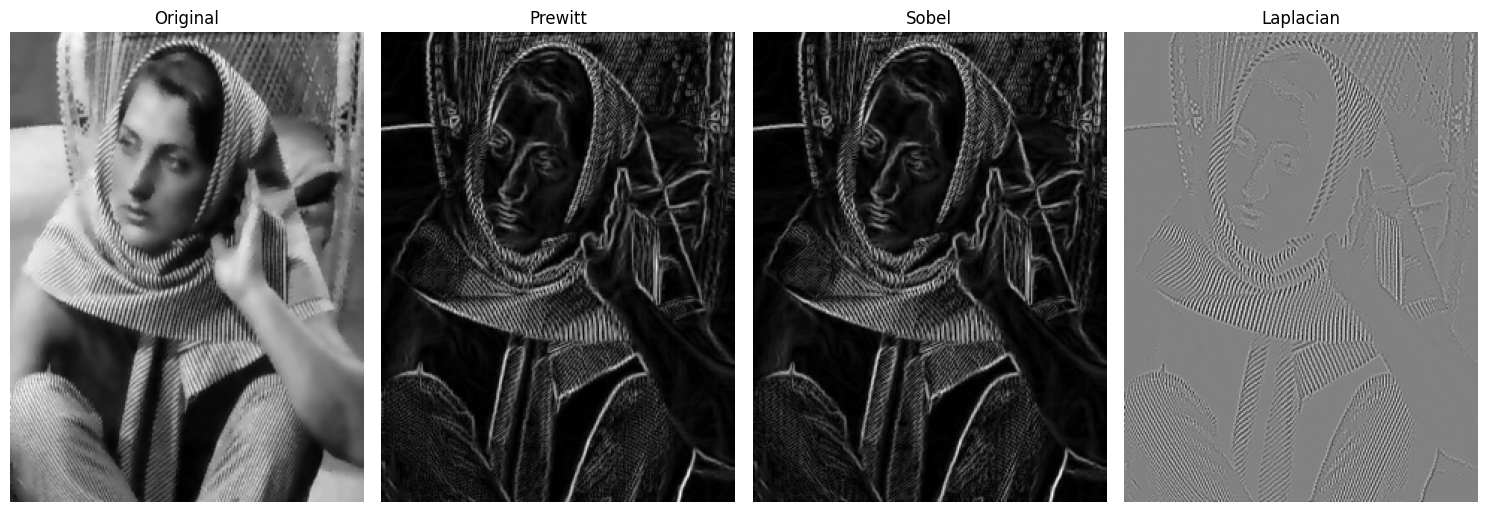

In [ ]:
# Load grayscale image
img1 = cv2.imread('../images/q1/gaussian.png', cv2.IMREAD_GRAYSCALE)

# Part (b)
display_edge_detection(img1)

In [ ]:
def laplacian_unsharp(image):
    lap = laplacian_filter(image)
    return np.clip(image + lap, 0, 255).astype(np.uint8)

def highboost_filter(image, a, ksize=5, sigma=1.0):
    blurred = gaussian_filter(image, ksize, sigma)
    mask = image - blurred
    return np.clip(image + a * mask, 0, 255).astype(np.uint8)

def display_sharpening(image):
    unsharp = laplacian_unsharp(image)
    boost_vals = [1.5, 2.5, 5.0]
    boosted = [highboost_filter(image, a) for a in boost_vals]
    
    fig, axs = plt.subplots(1, 5, figsize=(20, 5))
    titles = ["Original", "Unsharp"] + [f"Highboost a={a}" for a in boost_vals]
    images = [image, unsharp] + boosted

    for i in range(5):
        axs[i].imshow(images[i], cmap='gray')
        axs[i].set_title(titles[i])
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()


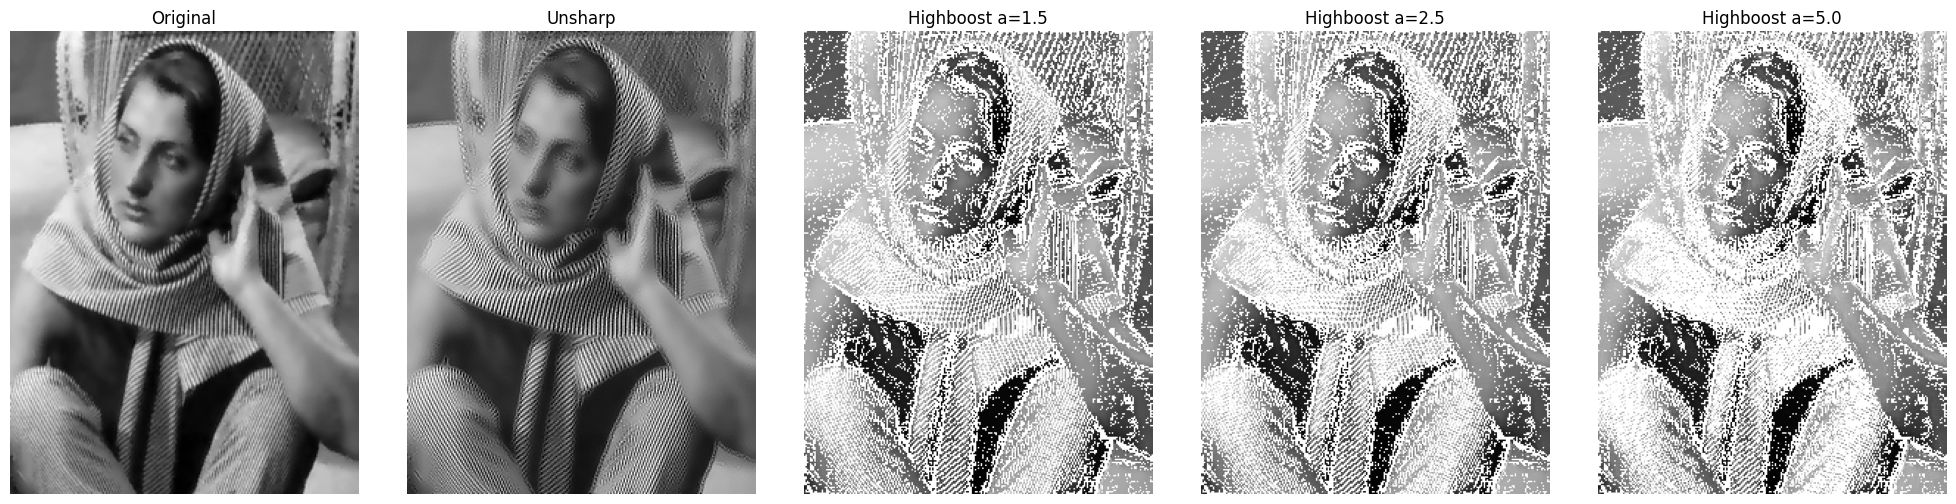

In [24]:
# Load grayscale image
img1 = cv2.imread('../images/q1/gaussian.png', cv2.IMREAD_GRAYSCALE)

# Part (c)
display_sharpening(img1)


In [1]:
def compute_histogram_2d(channel):
    hist = np.zeros(256, dtype=np.int32)
    for value in channel.flatten():
        hist[value] += 1
    return hist

def compute_cdf(hist):
    cdf = np.cumsum(hist).astype(np.float64)
    cdf /= cdf[-1]  # Normalize to range [0, 1]
    return cdf

def match_histograms_2d(source, target):
    matched = np.zeros_like(source)

    for ch in range(3):  # For R, G, B channels
        src = source[:, :, ch]
        tgt = target[:, :, ch]

        hist_src = compute_histogram_2d(src)
        hist_tgt = compute_histogram_2d(tgt)

        cdf_src = compute_cdf(hist_src)
        cdf_tgt = compute_cdf(hist_tgt)

        # Create the mapping from source to target
        mapping = np.zeros(256, dtype=np.uint8)
        for i in range(256):
            diff = np.abs(cdf_src[i] - cdf_tgt)
            mapping[i] = np.argmin(diff)

        # Apply mapping
        matched[:, :, ch] = mapping[src]

    return matched


In [2]:
def plot_rgb_histogram(image, ax, title):
    colors = ['r', 'g', 'b']
    for i, color in enumerate(colors):
        hist = compute_histogram_2d(image[:, :, i])
        ax.plot(hist, color=color)
    ax.set_title(title)
    ax.set_xlim([0, 256])

def visualize_histogram_matching(source, target, matched):
    fig, axs = plt.subplots(2, 3, figsize=(15, 8))

    axs[0, 0].imshow(cv2.cvtColor(source, cv2.COLOR_BGR2RGB))
    axs[0, 0].set_title('Source Image')
    axs[0, 0].axis('off')

    axs[0, 1].imshow(cv2.cvtColor(target, cv2.COLOR_BGR2RGB))
    axs[0, 1].set_title('Target Image')
    axs[0, 1].axis('off')

    axs[0, 2].imshow(cv2.cvtColor(matched, cv2.COLOR_BGR2RGB))
    axs[0, 2].set_title('Histogram Matched Image')
    axs[0, 2].axis('off')

    plot_rgb_histogram(source, axs[1, 0], "Source Histogram")
    plot_rgb_histogram(target, axs[1, 1], "Target Histogram")
    plot_rgb_histogram(matched, axs[1, 2], "Matched Histogram")

    plt.tight_layout()
    plt.show()


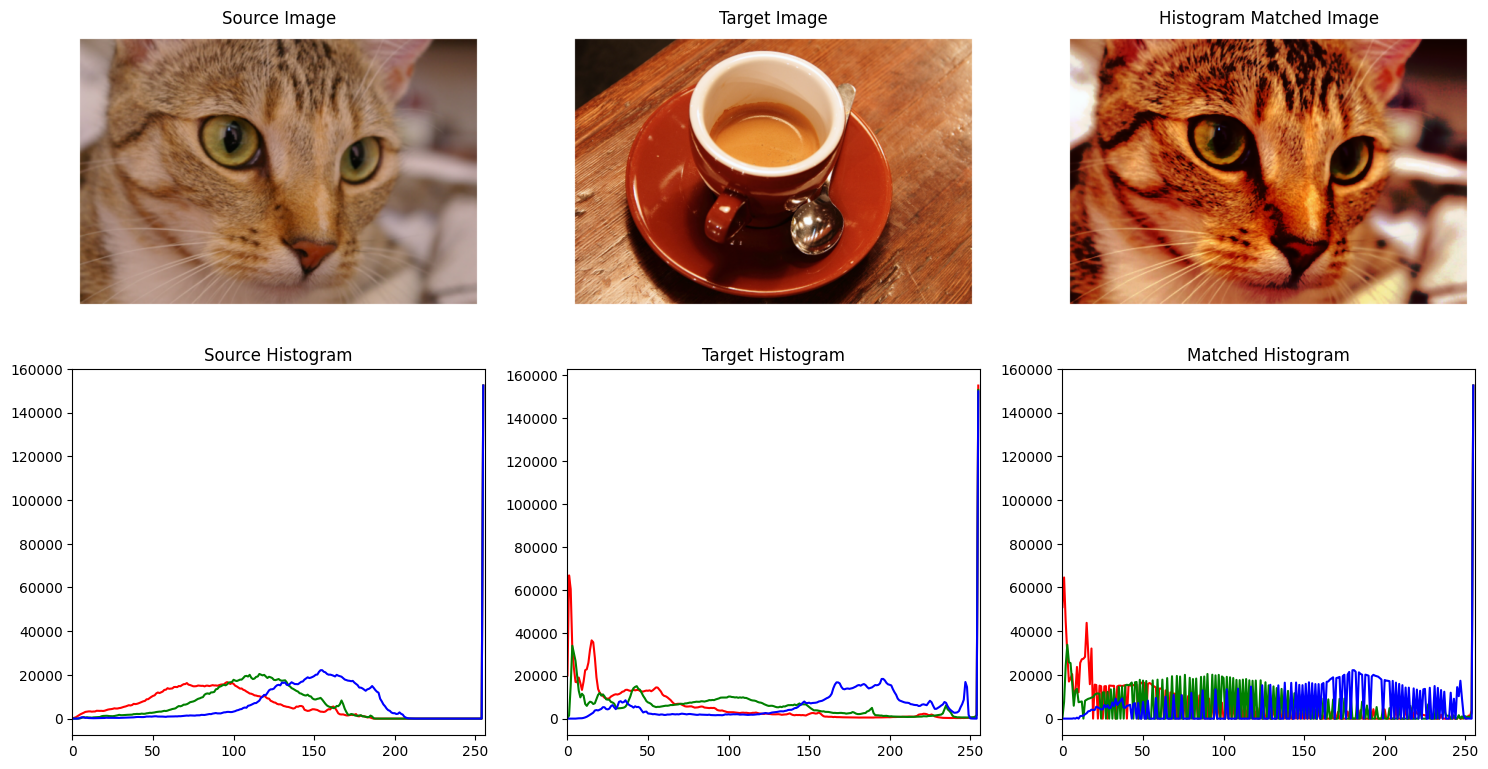

In [ ]:
source = cv2.imread('../images/q2/source_image.png')
target = cv2.imread('../images/q2/target_image.png')

matched = match_histograms_2d(source, target)
visualize_histogram_matching(source, target, matched)


In [6]:
def test_self_matching(image):
    matched = match_histograms_2d(image, image)
    visualize_histogram_matching(image, image, matched)

def test_bright_to_dark(bright_img, dark_img):
    matched = match_histograms_2d(bright_img, dark_img)
    visualize_histogram_matching(bright_img, dark_img, matched)

def match_to_uniform(image):
    target_cdf = np.linspace(0, 1, 256)

    matched = np.zeros_like(image)
    for ch in range(3):
        src = image[:, :, ch]
        hist = compute_histogram_2d(src)
        cdf_src = compute_cdf(hist)

        # Mapping to uniform CDF
        mapping = np.zeros(256, dtype=np.uint8)
        for i in range(256):
            diff = np.abs(cdf_src[i] - target_cdf)
            mapping[i] = np.argmin(diff)

        matched[:, :, ch] = mapping[src]

    return matched

def test_uniform_matching(image):
    matched = match_to_uniform(image)
    visualize_histogram_matching(image, np.full_like(image, 127), matched)


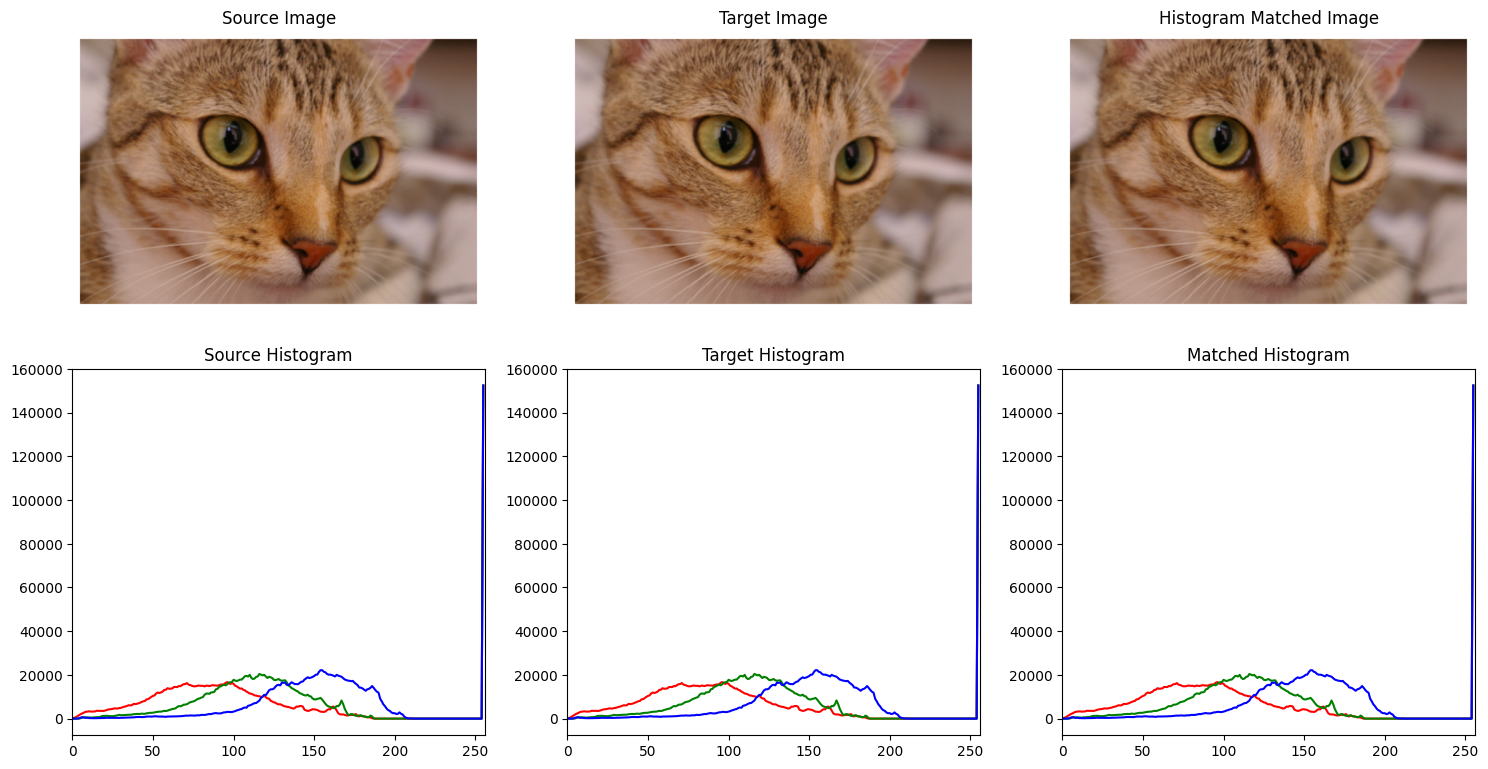

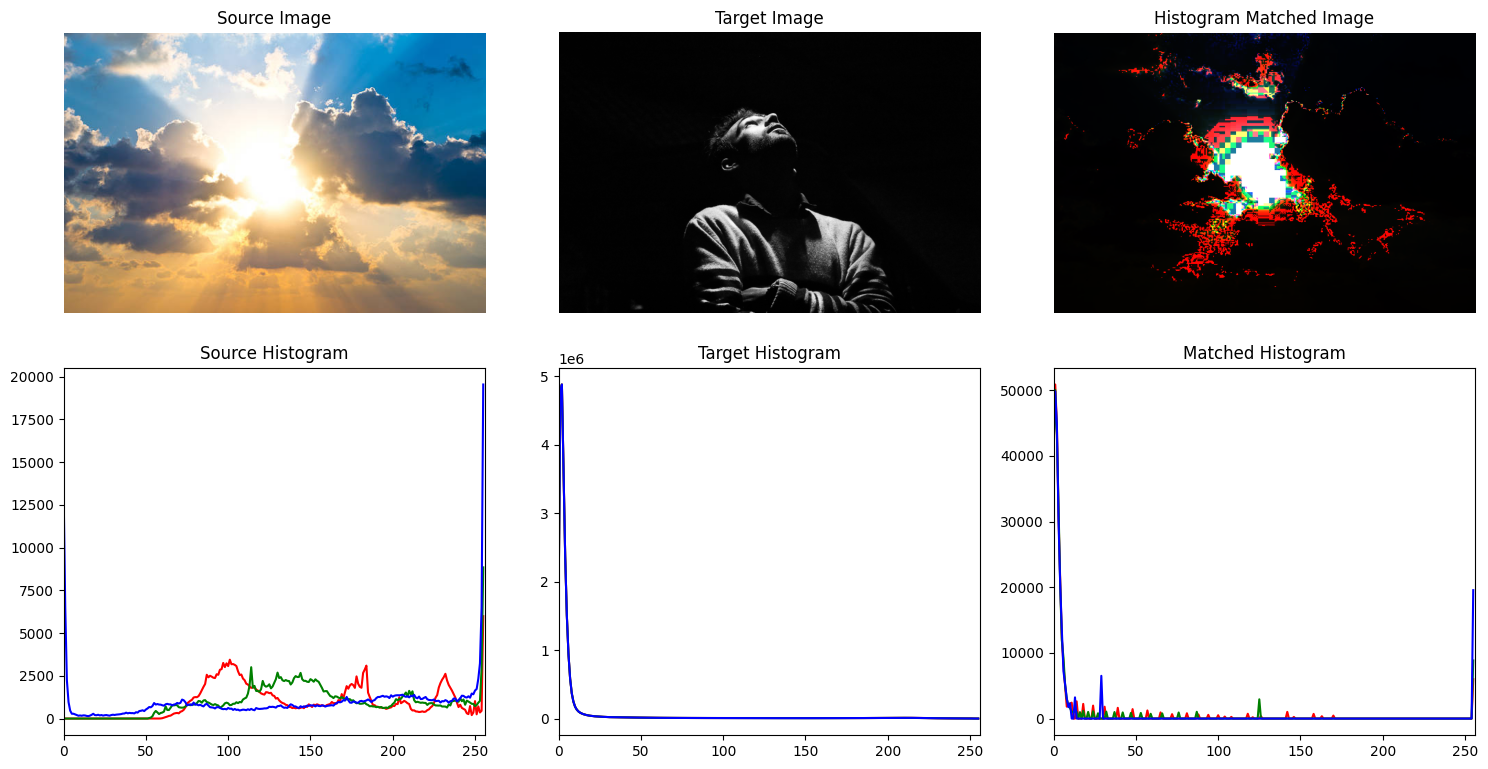

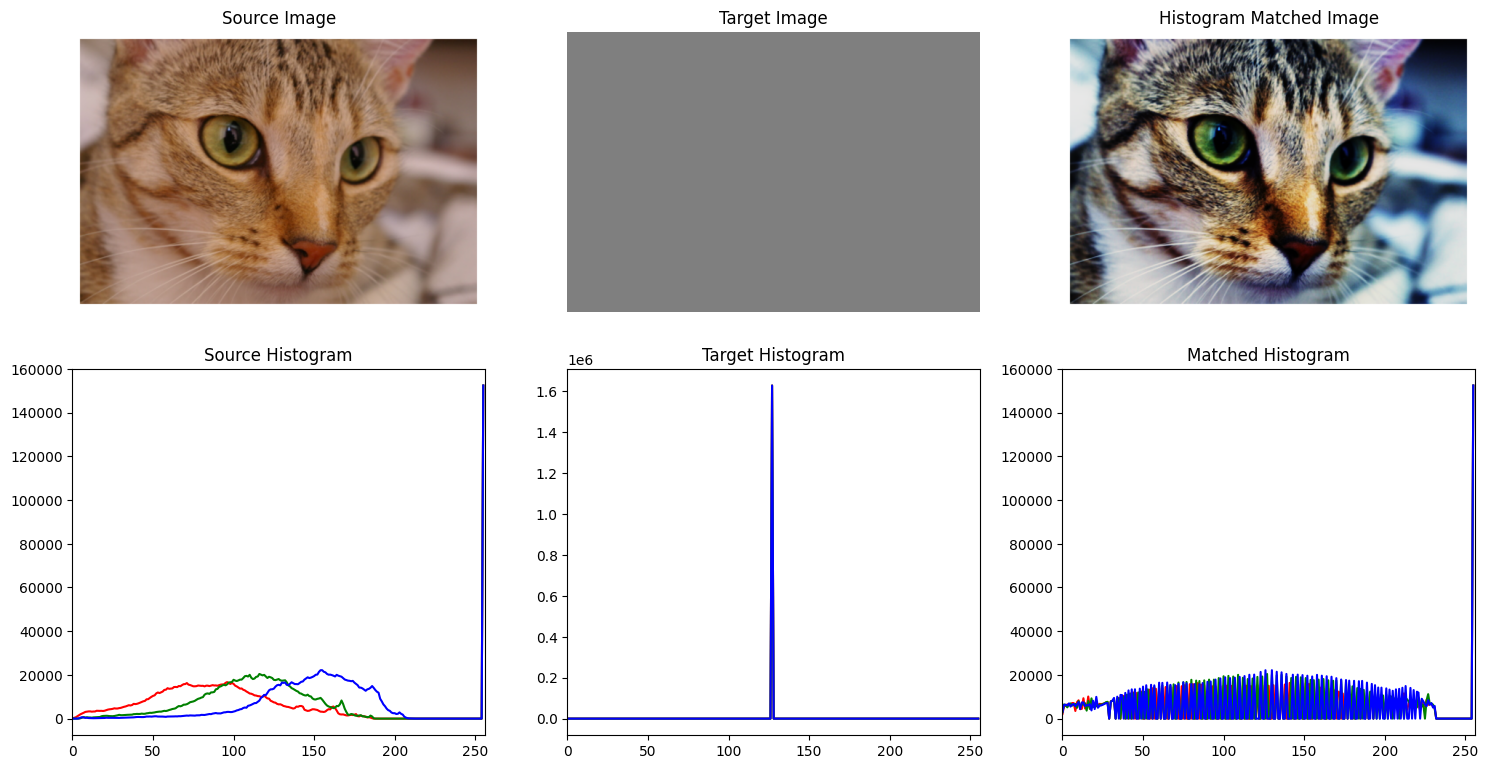

In [9]:
# Self-matching
test_self_matching(source)

# Bright vs dark
bright = cv2.imread('../images/q2/bright.jpg')
dark = cv2.imread('../images/q2/dark.jpg')
test_bright_to_dark(bright, dark)

# Uniform histogram
test_uniform_matching(source)

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def extract_bit_planes(image):
    bit_planes = []
    for i in range(8):
        bit_plane = ((image >> i) & 1) * 255
        bit_planes.append(bit_plane.astype(np.uint8))
    return bit_planes

def plot_bit_planes(image):
    bit_planes = extract_bit_planes(image)
    fig, axs = plt.subplots(2, 4, figsize=(12, 6))
    for i in range(8):
        ax = axs[i//4, i%4]
        ax.imshow(bit_planes[i], cmap='gray')
        ax.set_title(f'Bit Plane {i}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    return bit_planes


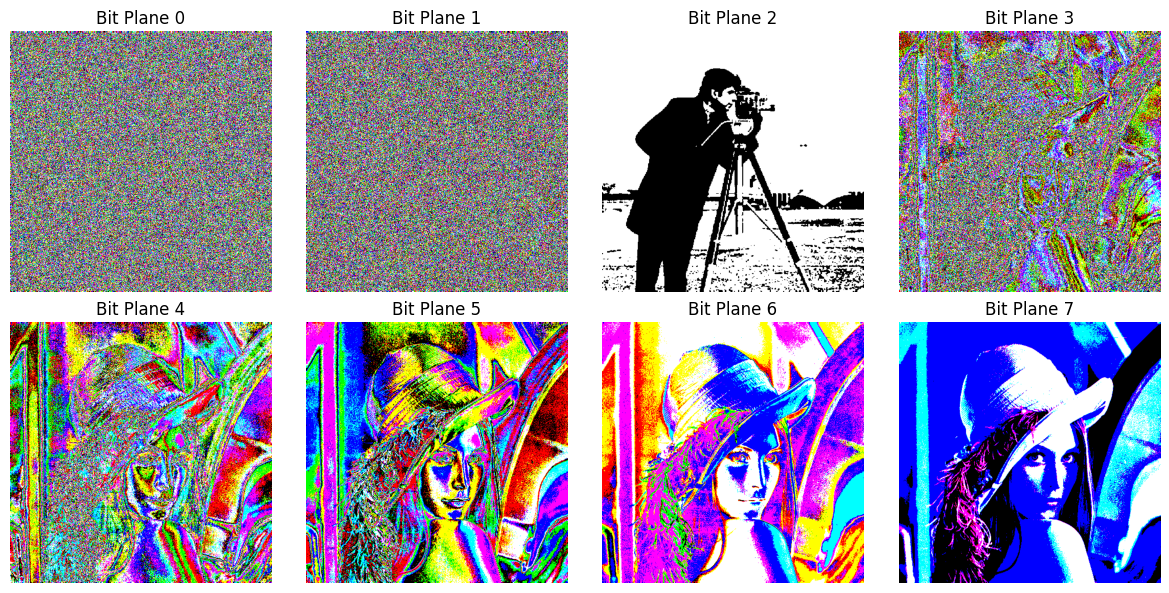

In [17]:
stego_img = cv2.imread('../images/q3/encrypted_image.png')
bit_planes = plot_bit_planes(stego_img)

In [27]:
def encrypt(cover_img, secret_img, bit_plane=0):
    cover = cover_img.copy()

    # Convert secret to grayscale if colored
    if secret_img.ndim == 3:
        secret_img = cv2.cvtColor(secret_img, cv2.COLOR_BGR2GRAY)

    # Resize and binarize
    secret = cv2.resize(secret_img, (cover.shape[1], cover.shape[0]))
    secret = (secret > 127).astype(np.uint8)

    # Compute the safe bit-clear mask
    mask = 255 - (1 << bit_plane)  # ✅ avoids overflow

    if cover.ndim == 3:  # Color image
        for ch in range(3):
            cover[:, :, ch] &= mask
            cover[:, :, ch] |= (secret << bit_plane)
    else:
        cover &= mask
        cover |= (secret << bit_plane)

    return cover

def decrypt(stego_img, bit_plane=0):
    secret = ((stego_img >> bit_plane) & 1) * 255
    return secret.astype(np.uint8)


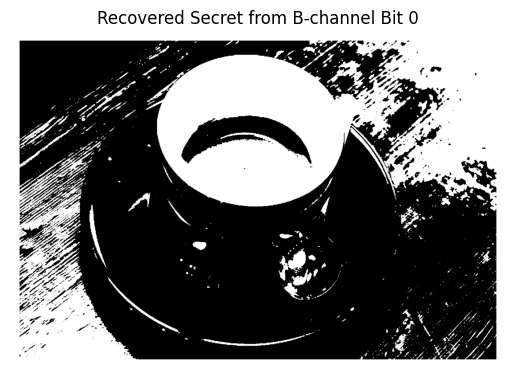

In [29]:
cover = cv2.imread('../images/q3/source_image.png')
secret = cv2.imread('../images/q3/target_image.png')

stego = encrypt(cover, secret, bit_plane=0)
cv2.imwrite('stego_generated.png', stego)

recovered = decrypt(stego, bit_plane=0)
plt.imshow(recovered, cmap='gray')
plt.title("Recovered Secret from B-channel Bit 0")
plt.axis('off')
plt.show()


In [ ]:
def hdr_merge(images, exposures):
    images = [img.astype(np.float32) for img in images]
    exposures = np.array(exposures, dtype=np.float32)

    numerator = np.zeros_like(images[0], dtype=np.float32)
    denominator = np.zeros_like(images[0], dtype=np.float32)

    for i in range(len(images)):
        weight = 1.0 / exposures[i]
        numerator += images[i] * weight
        denominator += weight

    hdr = numerator / denominator
    return hdr  


In [ ]:
img1 = cv2.imread('../images/q4/low_exp.png')
img2 = cv2.imread('../images/q4/med_exp.png')
img3 = cv2.imread('../images/q4/high_exp.png')

images = [img1, img2, img3]
exposures = [0.25, 2.5, 15.0]

hdr = hdr_merge(images, exposures)

In [ ]:
def tone_map(hdr_image, gamma=2.2):
    log_image = np.log1p(hdr_image)

    log_image -= log_image.min()
    log_image /= log_image.max()

    gamma_corrected = np.power(log_image, 1.0 / gamma)

    return (gamma_corrected * 255).astype(np.uint8)


In [6]:
tone_mapped = tone_map(hdr)

In [7]:
def show_hdr_results(images, hdr_tone_mapped):
    titles = ['Low Exposure', 'Medium Exposure', 'High Exposure', 'HDR Output']
    plt.figure(figsize=(20, 5))
    
    for i in range(3):
        plt.subplot(1, 4, i+1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title(titles[i])
        plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(cv2.cvtColor(hdr_tone_mapped, cv2.COLOR_BGR2RGB))
    plt.title(titles[3])
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


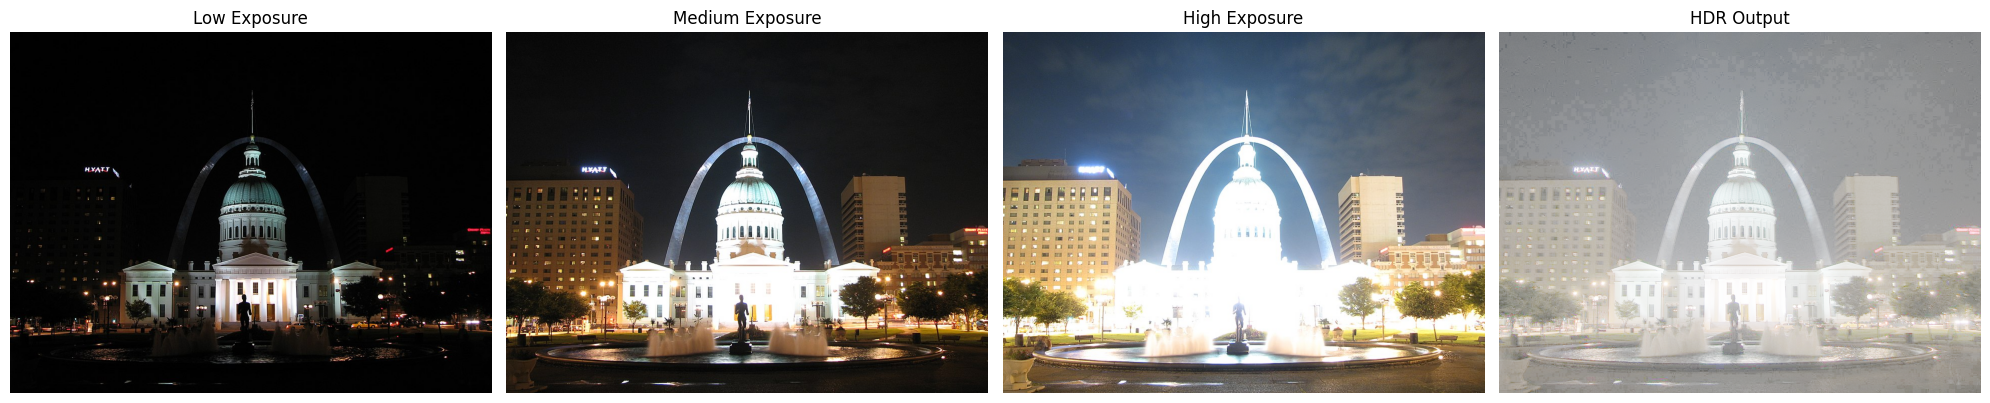

In [ ]:
show_hdr_results(images, tone_mapped)